In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import nltk

# Download necessary NLTK data
nltk.download('wordnet')  # Required for WordNetLemmatizer
nltk.download('omw-1.4')  # Required for wordnet support for Lemmatizer
nltk.download('stopwords')  # Required for stopword removal
nltk.download('punkt')  # Required for tokenization


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
import nltk
import os
import zipfile

# Define the NLTK data path
nltk_data_path = "/kaggle/working/nltk_data"
os.makedirs(nltk_data_path, exist_ok=True)

# Add the path to NLTK's search paths
nltk.data.path.append(nltk_data_path)

# Download required resources
nltk.download('wordnet', download_dir=nltk_data_path)
nltk.download('omw-1.4', download_dir=nltk_data_path)
nltk.download('stopwords', download_dir=nltk_data_path)
nltk.download('punkt', download_dir=nltk_data_path)

# Extract .zip files in /corpora
for zip_file in ['wordnet.zip', 'omw-1.4.zip']:
    with zipfile.ZipFile(f"{nltk_data_path}/corpora/{zip_file}", 'r') as zip_ref:
        zip_ref.extractall(f"{nltk_data_path}/corpora")

# Verify extracted content
print("Extracted corpora:", os.listdir(f"{nltk_data_path}/corpora"))

# Test wordnet
from nltk.corpus import wordnet
print(wordnet.synsets('test'))  # Should print a list of synsets

# Test stopwords
from nltk.corpus import stopwords
print(stopwords.words('english')[:10])  # Should print the first 10 English stopwords


[nltk_data] Downloading package wordnet to
[nltk_data]     /kaggle/working/nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /kaggle/working/nltk_data...
[nltk_data] Downloading package stopwords to
[nltk_data]     /kaggle/working/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /kaggle/working/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Extracted corpora: ['stopwords.zip', 'wordnet', 'omw-1.4', 'stopwords', 'wordnet.zip', 'omw-1.4.zip']
[Synset('trial.n.02'), Synset('test.n.02'), Synset('examination.n.02'), Synset('test.n.04'), Synset('test.n.05'), Synset('test.n.06'), Synset('test.v.01'), Synset('screen.v.01'), Synset('quiz.v.01'), Synset('test.v.04'), Synset('test.v.05'), Synset('test.v.06'), Synset('test.v.07')]
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [4]:
# Necessary imports
import os
import numpy as np
import pandas as pd
import torch
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.models as models
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

In [5]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Initialize stop words and lemmatizer
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Text preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    return " ".join(lemmas)


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
# Data loading functions
def load_text_data(data_folder):
    texts = []
    filenames = sorted(os.listdir(data_folder), key=lambda x: int(x[:-4]) if x[:-4].isdigit() else x)
    for filename in filenames:
        if filename.endswith(".txt"):
            with open(os.path.join(data_folder, filename), 'r', encoding='latin-1') as file:
                text = file.read().strip()
                texts.append(text)
    return texts, filenames

def load_labels(result_file):
    labels = {}
    with open(result_file, 'r') as file:
        next(file)  # Skip header
        for line in file:
            parts = line.strip().split('\t')
            text_id = int(parts[0])
            text_label, image_label = parts[1].split(',')
            labels[text_id] = (text_label.strip(), image_label.strip())
    return labels

def filter_existing_files(texts, filenames, labels, data_folder):
    existing_texts = []
    existing_images = []
    existing_labels = []
    for i, text in enumerate(texts):
        image_file = os.path.join(data_folder, f"{i+1}.jpg")
        if os.path.exists(image_file) and (i+1) in labels:
            existing_texts.append(text)
            existing_images.append(image_file)
            existing_labels.append(labels[i+1])
    return existing_texts, existing_images, existing_labels


In [7]:
# Multimodal label function
def multimodal_label(text_label, image_label):
    if text_label == image_label:
        return text_label
    elif text_label == 'neutral':
        return image_label
    elif image_label == 'neutral':
        return text_label
    else:
        return text_label  # Prioritize text label in case of conflict


In [8]:
# Dataset class
class MultimodalDataset(Dataset):
    def __init__(self, texts, images, labels, tokenizer, transform):
        self.texts = texts
        self.images = images
        self.labels = labels
        self.tokenizer = tokenizer
        self.transform = transform

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        image_path = self.images[idx]
        text_label, image_label = self.labels[idx]

        try:
            image = Image.open(image_path).convert('RGB')
        except FileNotFoundError:
            print(f"File not found: {image_path}")
            image = Image.new('RGB', (224, 224))  # Create a blank image

        # Preprocess text
        processed_text = preprocess_text(text)

        # Tokenize text
        encoded_text = self.tokenizer(processed_text, padding='max_length', truncation=True, max_length=128, return_tensors='pt')

        # Transform image
        image = self.transform(image)

        # Combine labels
        label = multimodal_label(text_label, image_label)

        # Map label to integer
        label_id = self.sentiment_to_label[label]

        return {
            'text': encoded_text['input_ids'].squeeze(),
            'attention_mask': encoded_text['attention_mask'].squeeze(),
            'image': image,
            'label': torch.tensor(label_id, dtype=torch.long)
        }

    sentiment_to_label = {'negative': 0, 'neutral': 1, 'positive': 2}

# Paths
data_folder = "/kaggle/input/mvsasingle/MVSA_Single/data/"
result_file = '/kaggle/input/mvsasingle/MVSA_Single/labelResultAll.txt'

# Load data
texts, filenames = load_text_data(data_folder)
labels = load_labels(result_file)

# Filter existing files
texts, image_paths, labels = filter_existing_files(texts, filenames, labels, data_folder)

# Tokenizer and transforms
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Split the data
train_texts, val_texts, train_images, val_images, train_labels, val_labels = train_test_split(
    texts, image_paths, labels, test_size=0.3, random_state=42, stratify=labels
)

# Create datasets and dataloaders
train_dataset = MultimodalDataset(train_texts, train_images, train_labels, tokenizer, train_transform)
val_dataset = MultimodalDataset(val_texts, val_images, val_labels, tokenizer, val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [9]:
# Model class
class MultimodalSentimentModel(nn.Module):
    def __init__(self, bert_model, resnet_model, num_classes):
        super(MultimodalSentimentModel, self).__init__()
        self.text_model = bert_model
        self.image_model = resnet_model
        
        self.text_output_size = 768  # BERT output size
        self.image_output_size = 2048  # ResNet50 output size
        
        self.attention = nn.MultiheadAttention(self.text_output_size + self.image_output_size, 8)
        self.fc1 = nn.Linear(self.text_output_size + self.image_output_size, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, input_ids, attention_mask, image):
        text_output = self.text_model(input_ids=input_ids, attention_mask=attention_mask)[1]
        image_output = self.image_model(image)
        
        combined = torch.cat((text_output, image_output), dim=1)
        combined = combined.unsqueeze(0)
        attn_output, _ = self.attention(combined, combined, combined)
        attn_output = attn_output.squeeze(0)
        
        x = self.fc1(attn_output)
        x = self.dropout(x)
        x = self.fc2(x)
        return x



In [10]:
# Initialize models
bert_model = BertModel.from_pretrained('bert-base-uncased')
resnet_model = models.resnet50(pretrained=True)
resnet_model.fc = nn.Identity()  # Remove the final fully connected layer
model = MultimodalSentimentModel(bert_model, resnet_model, num_classes=3).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [11]:
# Training and validation loop
num_epochs = 30
best_val_loss = float('inf')
patience = 10
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for batch in train_loader:
        input_ids = batch['text'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        images = batch['image'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask, images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()

    train_loss /= len(train_loader)
    train_acc = train_correct / train_total

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['text'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask, images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

            # Collecting data for ROC and Confusion Matrix
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())  # Probabilities for ROC

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping")
            break


Epoch 1/30:
Train Loss: 0.8876, Train Acc: 0.5753
Val Loss: 0.8190, Val Acc: 0.6175
Epoch 2/30:
Train Loss: 0.7998, Train Acc: 0.6324
Val Loss: 0.8190, Val Acc: 0.6153
Epoch 3/30:
Train Loss: 0.6883, Train Acc: 0.6916
Val Loss: 0.8186, Val Acc: 0.6493
Epoch 4/30:
Train Loss: 0.5234, Train Acc: 0.7855
Val Loss: 0.9736, Val Acc: 0.6305
Epoch 5/30:
Train Loss: 0.3518, Train Acc: 0.8596
Val Loss: 1.2236, Val Acc: 0.6139
Epoch 6/30:
Train Loss: 0.2022, Train Acc: 0.9231
Val Loss: 1.4584, Val Acc: 0.6095
Epoch 7/30:
Train Loss: 0.1621, Train Acc: 0.9470
Val Loss: 1.6198, Val Acc: 0.6168
Epoch 8/30:
Train Loss: 0.0937, Train Acc: 0.9693
Val Loss: 1.6743, Val Acc: 0.6168
Epoch 9/30:
Train Loss: 0.0774, Train Acc: 0.9780
Val Loss: 1.7470, Val Acc: 0.6161
Epoch 10/30:
Train Loss: 0.0625, Train Acc: 0.9805
Val Loss: 1.7645, Val Acc: 0.6110
Epoch 11/30:
Train Loss: 0.0634, Train Acc: 0.9780
Val Loss: 1.8806, Val Acc: 0.6117
Epoch 12/30:
Train Loss: 0.0646, Train Acc: 0.9777
Val Loss: 1.8710, Val A

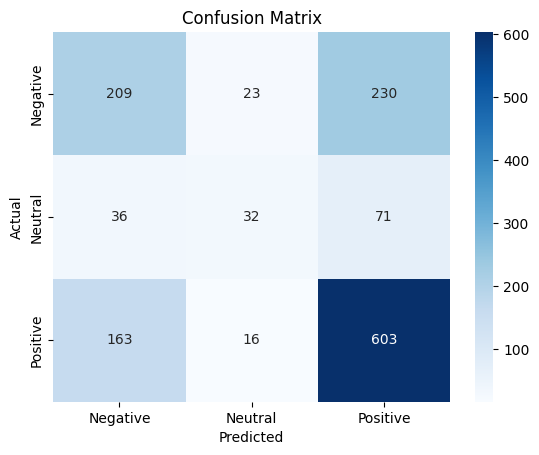

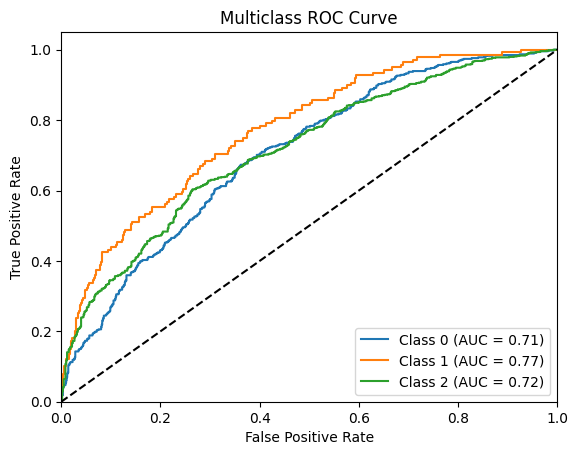

              precision    recall  f1-score   support

    Negative       0.51      0.45      0.48       462
     Neutral       0.45      0.23      0.30       139
    Positive       0.67      0.77      0.72       782

    accuracy                           0.61      1383
   macro avg       0.54      0.48      0.50      1383
weighted avg       0.59      0.61      0.60      1383



In [12]:
# Evaluation: Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve (one-vs-rest)
fpr = {}
tpr = {}
roc_auc = {}

# Binarize the labels for ROC calculation
all_labels_bin = np.eye(3)[all_labels]

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], np.array(all_probs)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Classification Report
print(classification_report(all_labels, all_preds, target_names=['Negative', 'Neutral', 'Positive']))
